# Inference Notebook for General VQA task

In [1]:
cd ..

/Users/zagaraa/Documents/GitHub/visionaid-vqa


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
ls

README.md         data/             notebooks/        scripts/
app.py            models/           outputs/          vqa/
assets/           modules/          requirements.txt


# Custom Vision and Language Transformer (ViLT)

In [4]:
import torch
from PIL import Image
from transformers import ViltProcessor, ViltForQuestionAnswering
import matplotlib.pyplot as plt

def predict_vqa(image_path, question, model_path="models/vilt_finetuned_vizwiz2"):
    # Load model and processor
    processor = ViltProcessor.from_pretrained(model_path)
    model = ViltForQuestionAnswering.from_pretrained(model_path)
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Load id2label
    id2label = model.config.id2label

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB").resize((384, 384))

    # Prepare input
    inputs = processor(image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_id = logits.argmax(-1).item()
        predicted_label = id2label.get(predicted_id, f"unknown_{predicted_id}").lower()

    # Display image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(
        f"Q: {question}\nPredicted: {predicted_label}",
        fontsize=10,
        loc='left',
        wrap=True
    )
    plt.tight_layout()
    plt.show()

    return predicted_label

/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


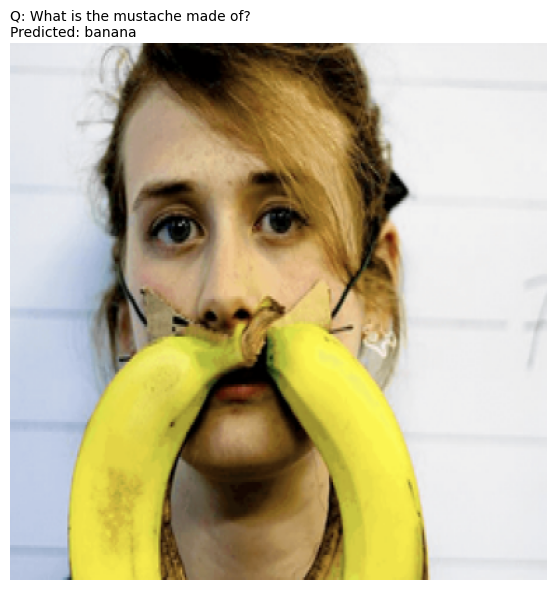

Predicted label: banana


In [5]:
image_path = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/assets/vqa1.png"
question = "What is the mustache made of?"

predicted = predict_vqa(image_path, question)
print("Predicted label:", predicted)

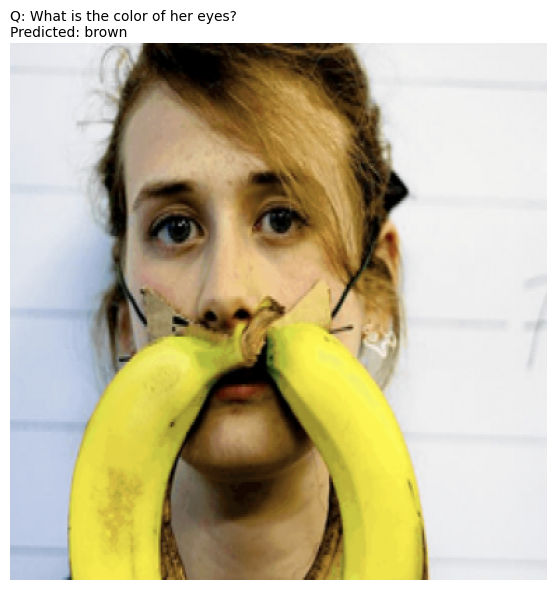

Predicted label: brown


In [6]:
image_path = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/assets/vqa1.png"
question = "What is the color of her eyes?"

predicted = predict_vqa(image_path, question)
print("Predicted label:", predicted)

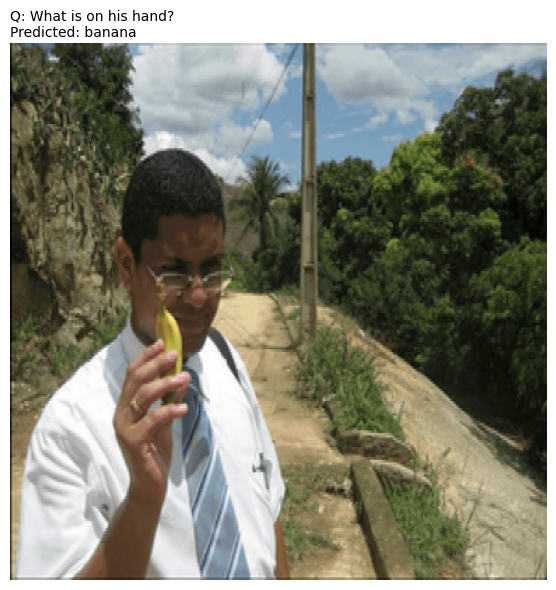

Predicted label: banana


In [7]:
image_path = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/assets/vqa2.png"
question = "What is on his hand?"

predicted = predict_vqa(image_path, question)
print("Predicted label:", predicted)

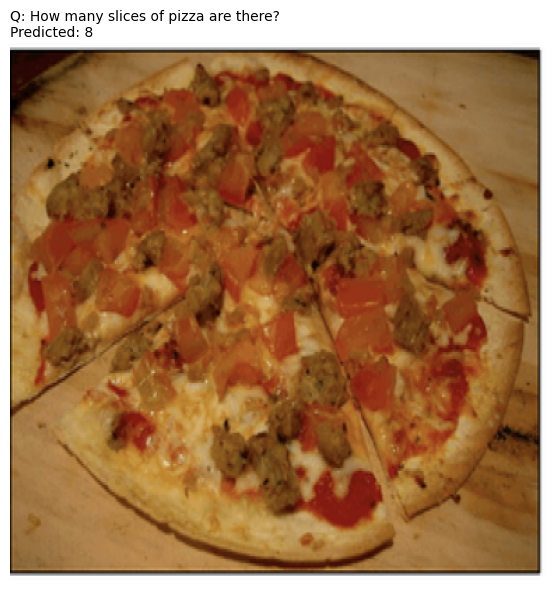

Predicted label: 8


In [8]:
image_path = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/assets/vqa3.png"
question = "How many slices of pizza are there?"

predicted = predict_vqa(image_path, question)
print("Predicted label:", predicted)

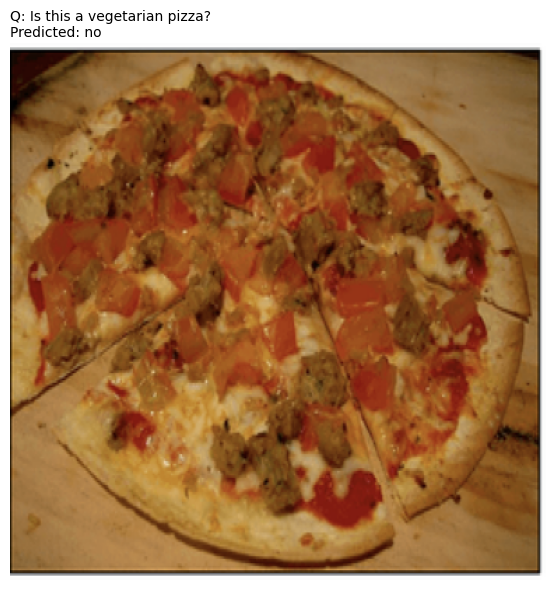

Predicted label: no


In [9]:
image_path = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/assets/vqa3.png"
question = "Is this a vegetarian pizza?"

predicted = predict_vqa(image_path, question)
print("Predicted label:", predicted)

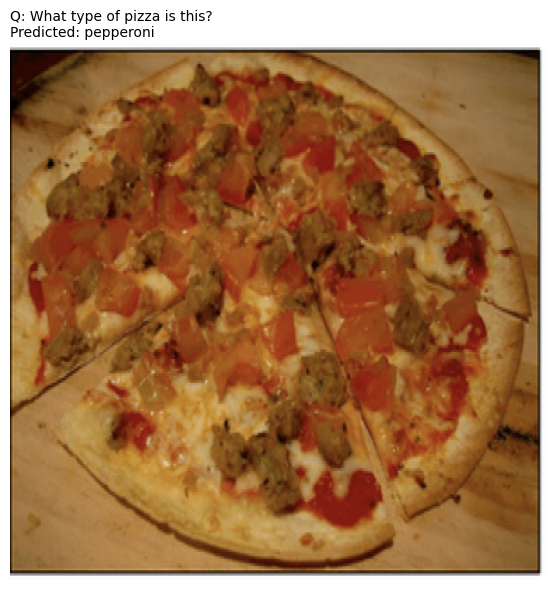

Predicted label: pepperoni


In [10]:
image_path = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/assets/vqa3.png"
question = "What type of pizza is this?"

predicted = predict_vqa(image_path, question)
print("Predicted label:", predicted)

# BLIP2

In [12]:
import torch
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

# Load the processor and model.
# Note: The parameter load_in_4bit=True instructs Transformers (and Bitsandbytes) to load the model in 4‑bit precision.
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    load_in_4bit=True,          # Enable 4-bit inference using Bitsandbytes
    device_map="auto"           # Automatically maps the model to the available devices
)

model.eval()  # Switch to evaluation mode

# Download and prepare the image.
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

question = "how many dogs are in the picture?"
inputs = processor(raw_image, question, return_tensors="pt")

# If you are using CPU, you might want to move your tensors to CPU explicitly.
inputs = {key: value.to("cpu") for key, value in inputs.items()}

# Run inference with torch.inference_mode() to avoid gradient calculations.
with torch.inference_mode():
    generated_ids = model.generate(**inputs, max_new_tokens=40)
    answer = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print(answer.strip())


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

# Florence-2

In [3]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3,
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [272.32000732421875, 241.67999267578125, 303.67999267578125, 247.4399871826172], [454.0799865722656, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


In [4]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch
%matplotlib inline  

In [31]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

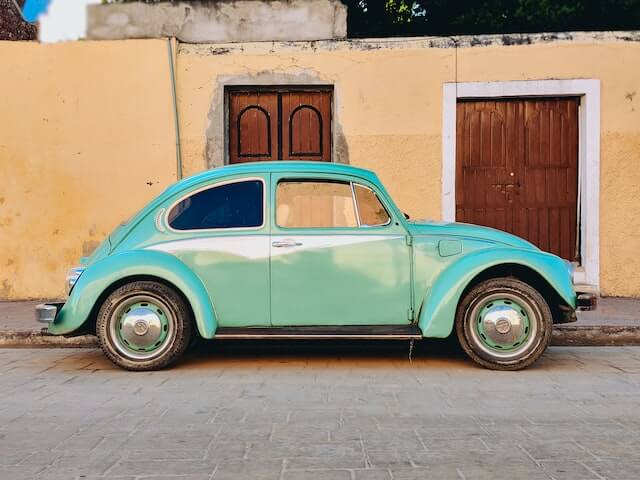

In [32]:
image

In [28]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


from transformers import AutoProcessor, AutoModelForCausalLM
import numpy as np

from unittest.mock import patch
import requests
import copy

from PIL import Image, ImageDraw, ImageFont 
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
import numpy as np


from transformers import AutoModelForCausalLM, AutoProcessor
from transformers.dynamic_module_utils import get_imports



def get_device_type():
    import torch
    if torch.cuda.is_available():  
        return "cuda"
    else: 
        if (torch.backends.mps.is_available() and torch.backends.mps.is_built()):
            return "mps"
        else:
            return "cpu"
        
model_id = 'microsoft/Florence-2-base-ft'

import subprocess
device = get_device_type()
if (device == "cuda"):
    subprocess.run('pip install flash-attn --no-build-isolation', env={'FLASH_ATTENTION_SKIP_CUDA_BUILD': "TRUE"}, shell=True)
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)
    model.to(device)
else:
    #https://huggingface.co/microsoft/Florence-2-base-ft/discussions/4
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)
    model.to(device)


A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of th

In [29]:
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer

In [33]:
task_prompt = '<CAPTION>'
run_example(task_prompt, image)

/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/transformers/pytorch_utils.py:337: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [35]:
cd ..

/Users/zagaraa/Documents/GitHub/visionaid-vqa


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [36]:
ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


README.md         data/             notebooks/        scripts/
app.py            models/           outputs/          vqa/
assets/           modules/          requirements.txt


In [41]:
!python scripts/inference_florence2.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/balanced_subset2/test/VizWiz_train_00001466.jpg --task_prompt "describe the scene"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin`